In [1]:
#pip install catboost <- run first time this notebook is executed
#pip install sklearn
#pip install tabulate

In [2]:
import pandas as pd
from catboost import CatBoostRegressor
import datetime
from sklearn import preprocessing
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
from IPython.display import HTML, display
import tabulate

In [4]:
df = pd.read_parquet('../data/forecasting_format/dataframe_forecasting_with_features.parquet')

# Forecasting, training with clusters

This notebook performs forecasting with Catboost, when trained on k-means clusters and hierarchical clusters respectivly. Each clustering method has four clusters. This notebook can be seen in connection with forecasting_w_catboost_single_country and forecasting_w_catboost_all_countries, as the ovjective of these notebooks are the same, however the training data differs.

As mentioned, the forecasting model is trained with clusters. This data is pre-processed using the pre_processing -> pre_processing notebook, formatted using the pre_processing -> forecasting_fromat_cases_per_day notebook and been given features by the pre_processing -> adding_features notebook. The clusters where found using respectivly the clustering -> clustering_k_means notebook and clustering -> clustering_hierarchical notebook. There has been selected 4 test countries that are the same for all forecasting. These were chosen at random with the condition that each of the four countries needed to be in a distinct cluster, where non of the three other test countries belonged. This had to be the case in both the k-means clusters and the hierarchical clusters. This is to ensure a fair comparison of the forecasts as possible.
<br>
<br>
Training period: 01-03-2020 -> 09-09-2020
<br>
Testinng period: 10-09-2020 -> 17-09-2020

Under testing, predictions where done with all combinations of features, this resulted in that the features 'weekday' and 'cases_tot' were disregarded, as prediction accuracy overall where effected negatively by these features. The used features are: 'Country', 'Month', 'Day', 'prev_case' where the last feature is a t-1 shift. These features are used for all forecasting predictions to ensure a fair basis of comparison as possible.

To evaluate accuracy, this and all forecasting notebooks utilize SMAPE, see paper for explanation and evaluation of this method of computing accuracy.

In [5]:
#Function used to perform prediction. Input: forecasting model, traning dataframe, test dataframe, 
#list of features, and number of predictions, default 8. Returns dataframe with same format as
#additional test_df, with an additional column with predictions.

def forecast(model, training_df, test_df, feature_list, num_predictions=8):
    start_period = 0
    end_period = num_predictions
    prediction_list = []
    
    #Generating an encoder for country feature by converting country string to int value
    if 'Country' in feature_list:
        ns_encoder = preprocessing.LabelEncoder()
        training_df['Country'] =  ns_encoder.fit_transform(training_df['Country'])
    
    #Dataframe with all features
    x_training_df = training_df[feature_list].copy()
    #Dataframe with all cases
    y_training_df = training_df['Cases'].copy().to_frame()
    model.fit(x_training_df, np.ravel(y_training_df))
    
    # Predicting on test set, while end period is not equal to end of length of test_df
    while end_period <= len(test_df):
        # Collect features from start to end and predict (10-10-2020->17-10-2020)
        features_df = test_df[feature_list][start_period:end_period].copy()
        #Generating an encoder for country feature by converting country string to int value
        if 'Country' in feature_list:
            features_df['Country'] = ns_encoder.transform(features_df['Country'])
        true_df = test_df[['Cases']][start_period:end_period].copy()
        predictions = model.predict(features_df)
       
        # Add the predicted data
        predicted_df = pd.DataFrame(predictions, columns=['predicted'])
        predicted_df.index = true_df.index.copy()        
        prediction_list.extend(predictions)
        # Move to next period
        start_period += 1
        end_period += 1
    
    df_result = test_df.assign(Predicted=prediction_list)
    return df_result

In [6]:
#Function that computes a SMAPE. Input: dataframe including true and prediction,
#true_column that specifies which column of df holds the true values and 
#pred_column that specifies which column of df hold the predicted values
def SMAPE(df,true_column,pred_column):
    true_list = df[true_column].to_numpy()
    pred_list = df[pred_column].to_numpy()
    return 1/len(true_list)*np.sum(2*np.abs(pred_list-true_list)/(np.abs(true_list)+np.abs(pred_list))*100)

In [7]:
#Function computes an additional column which sums predicted value together to form an accumulated
#prediction. Prediction for day 0 is summed to the known total cases the day before.
#Input: dataframe contanint all data on test country and dataframe including predictions produced
#by def forecast. 
def accumulated_dataframe_column(df_test_country,CB_df):
    test_start_value = df_test_country.loc[df_test_country.index == datetime.datetime(2020,9,9), 'cases_tot'].values[0]
    accumulated_list = [math.floor(test_start_value+CB_df['Predicted'][0])]
    for i in range(1,len(CB_df)):
        accumulated_list.append(math.floor(accumulated_list[i-1]+CB_df['Predicted'][i]))
    df_result = CB_df.copy()
    df_result['Accumulated_Prediction'] = accumulated_list
    return df_result

## Selecting test countries

In [8]:
Algeria_df = df[df['Country'].isin(['Algeria'])]

In [9]:
test_1_df =  Algeria_df[(Algeria_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Algeria_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [10]:
Belgium_df = df[df['Country'].isin(['Belgium'])]

In [11]:
test_2_df =  Belgium_df[(Belgium_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Belgium_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [12]:
Bangladesh_df = df[df['Country'].isin(['Bangladesh'])]

In [13]:
test_3_df =  Bangladesh_df[(Bangladesh_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Bangladesh_df.index.date <= datetime.date(2020, 9, 17))].copy()

In [14]:
Croatia_df = df[df['Country'].isin(['Croatia'])]

In [15]:
test_4_df =  Croatia_df[(Croatia_df.index.date > datetime.date(2020, 9, 9)) & 
                    (Croatia_df.index.date <= datetime.date(2020, 9, 17))].copy()

## K-means z trans, cluster 1

In [16]:
k_means_1_countries = pd.read_parquet('../results/clustering_results/df_kmeans_z_2.parquet')

In [17]:
k_means_1_countries_list = list(k_means_1_countries.columns)

List of countries in cluster:

In [18]:
k_means_1_countries_list

['Algeria',
 'Argentina',
 'Australia',
 'Bolivia',
 'Bulgaria',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'El Salvador',
 'Ethiopia',
 'India',
 'Indonesia',
 'Iraq',
 'Israel',
 'Japan',
 'Kazakhstan',
 'Kenya',
 'Malawi',
 'Mexico',
 'Mozambique',
 'Nepal',
 'Panama',
 'Philippines',
 'Romania',
 'Rwanda',
 'South Africa',
 'Ukraine',
 'Vietnam',
 'Zambia',
 'Zimbabwe']

In [19]:
k_means_1_df = df[df['Country'].isin(k_means_1_countries_list)]

In [20]:
k_means_1_training_df = k_means_1_df[(k_means_1_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_1_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [21]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
k_means_1_CB_df = forecast(model=model, training_df=k_means_1_training_df.copy(), 
                                                             test_df=test_1_df.copy(),
                                                             feature_list=feature_list)

In [22]:
k_means_1_CB_df = accumulated_dataframe_column(Algeria_df,k_means_1_CB_df)

In [23]:
k_means_1_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,278.0,Algeria,47216.0,9,3,0.0,285.0,335.449768,47273
2020-09-11,272.0,Algeria,47488.0,9,4,0.0,278.0,206.084140,47479
2020-09-12,264.0,Algeria,47752.0,9,5,1.0,272.0,312.238193,47791
2020-09-13,255.0,Algeria,48007.0,9,6,1.0,264.0,288.449134,48079
2020-09-14,247.0,Algeria,48254.0,9,0,0.0,255.0,225.938481,48304
2020-09-15,242.0,Algeria,48496.0,9,1,0.0,247.0,320.564446,48624
2020-09-16,238.0,Algeria,48734.0,9,2,0.0,242.0,310.368518,48934
2020-09-17,232.0,Algeria,48966.0,9,3,0.0,238.0,318.044670,49252


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

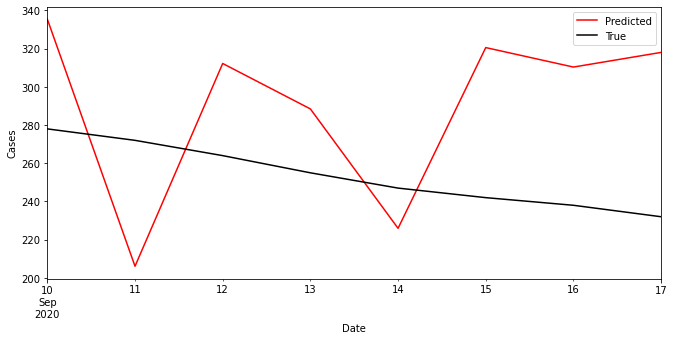

In [24]:
fig = plt.figure()
k_means_1_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

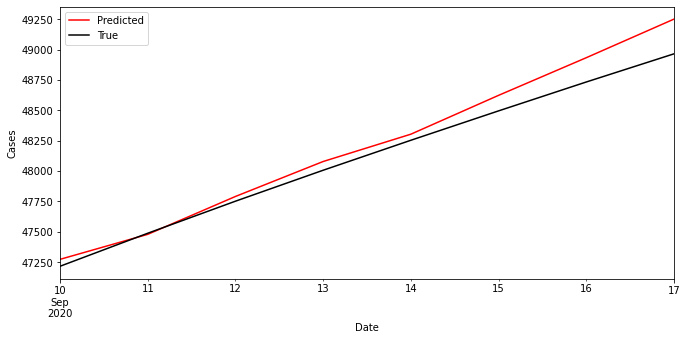

In [25]:
fig = plt.figure()
k_means_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Algeria_k_means", bbox_inches='tight')

SMAPE k_means 1:

In [26]:
round(SMAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2163

Saving result to parquet file:

In [27]:
#k_means_1_CB_df.to_parquet('../results/forecasting_results/forecast_with_k_means_algeria.parquet')

## Hierarchical z trans, cluster 1

In [28]:
hac_1_countries = pd.read_parquet('../results/clustering_results/df_hac_z_1.parquet')

In [29]:
hac_1_countries_list = list(hac_1_countries.columns)

List of countries in cluster:

In [30]:
hac_1_countries_list

['Algeria',
 'Argentina',
 'Bolivia',
 'Bulgaria',
 'Colombia',
 'Costa Rica',
 'Dominican Republic',
 'El Salvador',
 'Ethiopia',
 'India',
 'Indonesia',
 'Iraq',
 'Israel',
 'Kazakhstan',
 'Kenya',
 'Malawi',
 'Mexico',
 'Morocco',
 'Mozambique',
 'Nepal',
 'Panama',
 'Paraguay',
 'Philippines',
 'Rwanda',
 'South Africa',
 'Ukraine',
 'Zambia',
 'Zimbabwe']

In [31]:
hac_1_df = df[df['Country'].isin(hac_1_countries_list)]

In [32]:
hac_1_training_df = hac_1_df[(hac_1_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (hac_1_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [33]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
hac_1_CB_df = forecast(model=model, training_df=hac_1_training_df.copy(), 
                                                             test_df=test_1_df.copy(),
                                                             feature_list=feature_list)

In [34]:
hac_1_CB_df = accumulated_dataframe_column(Algeria_df,hac_1_CB_df)

In [35]:
hac_1_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,278.0,Algeria,47216.0,9,3,0.0,285.0,316.402955,47254
2020-09-11,272.0,Algeria,47488.0,9,4,0.0,278.0,184.729802,47438
2020-09-12,264.0,Algeria,47752.0,9,5,1.0,272.0,237.728279,47675
2020-09-13,255.0,Algeria,48007.0,9,6,1.0,264.0,93.174077,47768
2020-09-14,247.0,Algeria,48254.0,9,0,0.0,255.0,162.505923,47930
2020-09-15,242.0,Algeria,48496.0,9,1,0.0,247.0,327.627525,48257
2020-09-16,238.0,Algeria,48734.0,9,2,0.0,242.0,305.254689,48562
2020-09-17,232.0,Algeria,48966.0,9,3,0.0,238.0,298.517016,48860


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

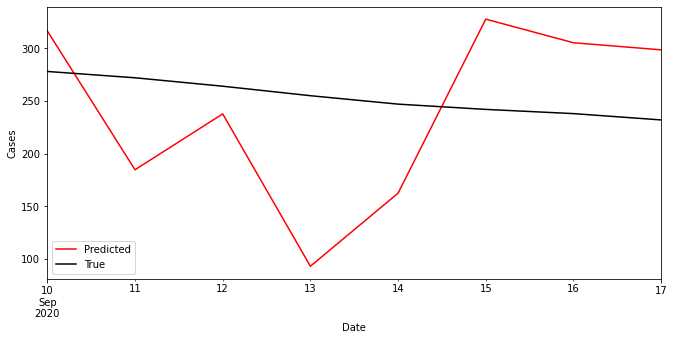

In [36]:
fig = plt.figure()
hac_1_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

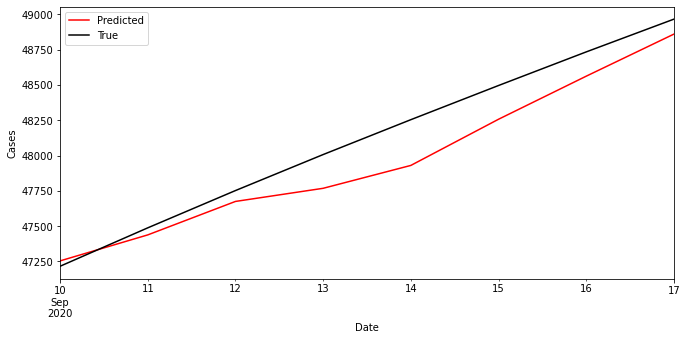

In [37]:
fig = plt.figure()
hac_1_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Algeria_hac", bbox_inches='tight')

SMAPE Hierarchical 1:

In [38]:
round(SMAPE(hac_1_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.323

Saving result to parquet file:

In [39]:
#hac_1_CB_df.to_parquet('../results/forecasting_results/forecast_with_hac_algeria.parquet')

## K-means z trans, cluster 2

In [40]:
k_means_2_countries = pd.read_parquet('../results/clustering_results/df_kmeans_z_3.parquet')

In [41]:
k_means_2_countries_list = list(k_means_2_countries.columns)

List of countries in cluster:

In [42]:
k_means_2_countries_list

['Austria',
 'Belgium',
 'Canada',
 'Denmark',
 'Estonia',
 'Fiji',
 'Finland',
 'Iceland',
 'Ireland',
 'Latvia',
 'Malaysia',
 'New Zealand',
 'Norway',
 'Switzerland',
 'Thailand',
 'Turkey',
 'United Kingdom']

In [43]:
k_means_2_df = df[df['Country'].isin(k_means_2_countries_list)]

In [44]:
k_means_2_training_df = k_means_2_df[(k_means_2_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_2_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [45]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
k_means_2_CB_df = forecast(model=model, training_df=k_means_2_training_df.copy(), 
                                                             test_df=test_2_df.copy(),
                                                             feature_list=feature_list)

In [46]:
k_means_2_CB_df = accumulated_dataframe_column(Belgium_df,k_means_2_CB_df)

In [47]:
k_means_2_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1023.0,Belgium,91868.0,9,3,0.0,872.0,808.899551,91653
2020-09-11,1141.0,Belgium,93009.0,9,4,0.0,1023.0,923.683693,92576
2020-09-12,1281.0,Belgium,94290.0,9,5,1.0,1141.0,910.298329,93486
2020-09-13,610.0,Belgium,94900.0,9,6,1.0,1281.0,791.653929,94277
2020-09-14,296.0,Belgium,95196.0,9,0,0.0,610.0,420.194938,94697
2020-09-15,1625.0,Belgium,96821.0,9,1,0.0,296.0,681.380010,95378
2020-09-16,898.0,Belgium,97719.0,9,2,0.0,1625.0,1370.110540,96748
2020-09-17,163.0,Belgium,97882.0,9,3,0.0,898.0,824.595942,97572


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

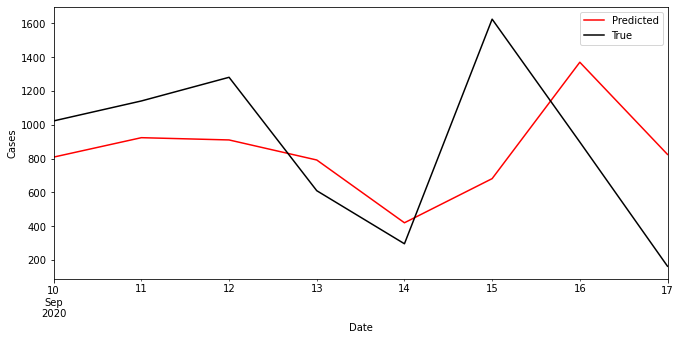

In [48]:
fig = plt.figure()
k_means_2_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

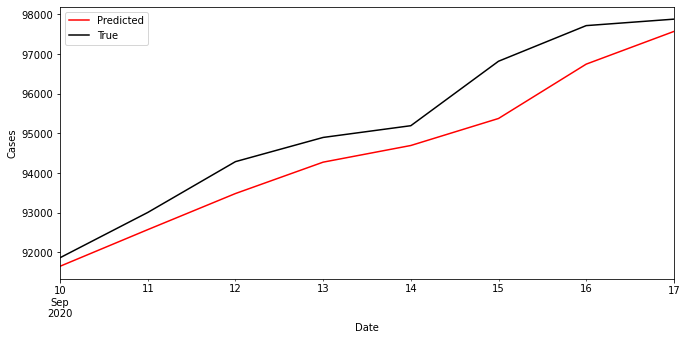

In [49]:
fig = plt.figure()
k_means_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Belgium_k_means", bbox_inches='tight')

SMAPE K-means 2:

In [50]:
round(SMAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.6949

Saving result to parquet file:

In [51]:
#k_means_2_CB_df.to_parquet('../results/forecasting_results/forecast_with_k_means_belgium.parquet')

## Hierarchical z trans, cluster 2

In [52]:
hac_2_countries = pd.read_parquet('../results/clustering_results/df_hac_z_3.parquet')

In [53]:
hac_2_countries_list = list(hac_2_countries.columns)

List of countries in cluster:

In [54]:
hac_2_countries_list

['Belgium',
 'Canada',
 'Denmark',
 'Estonia',
 'Fiji',
 'Finland',
 'Iceland',
 'Ireland',
 'Latvia',
 'Malaysia',
 'New Zealand',
 'Norway',
 'Switzerland',
 'Thailand',
 'Turkey',
 'United Kingdom']

In [55]:
hac_2_df = df[df['Country'].isin(hac_2_countries_list)]

In [56]:
hac_2_training_df = hac_2_df[(hac_2_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (hac_2_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [57]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
hac_2_CB_df = forecast(model=model, training_df=hac_2_training_df.copy(), 
                                                             test_df=test_2_df.copy(),
                                                             feature_list=feature_list)

In [58]:
hac_2_CB_df = accumulated_dataframe_column(Belgium_df,hac_2_CB_df)

In [59]:
hac_2_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1023.0,Belgium,91868.0,9,3,0.0,872.0,814.426390,91659
2020-09-11,1141.0,Belgium,93009.0,9,4,0.0,1023.0,944.183707,92603
2020-09-12,1281.0,Belgium,94290.0,9,5,1.0,1141.0,1003.258063,93606
2020-09-13,610.0,Belgium,94900.0,9,6,1.0,1281.0,761.701527,94367
2020-09-14,296.0,Belgium,95196.0,9,0,0.0,610.0,301.798401,94668
2020-09-15,1625.0,Belgium,96821.0,9,1,0.0,296.0,689.707224,95357
2020-09-16,898.0,Belgium,97719.0,9,2,0.0,1625.0,1455.576100,96812
2020-09-17,163.0,Belgium,97882.0,9,3,0.0,898.0,821.547048,97633


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

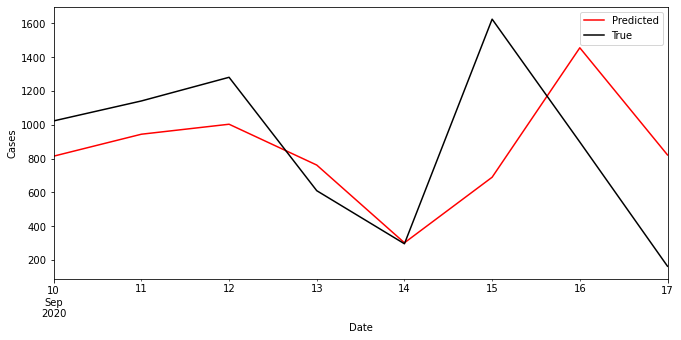

In [60]:
fig = plt.figure()
hac_2_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

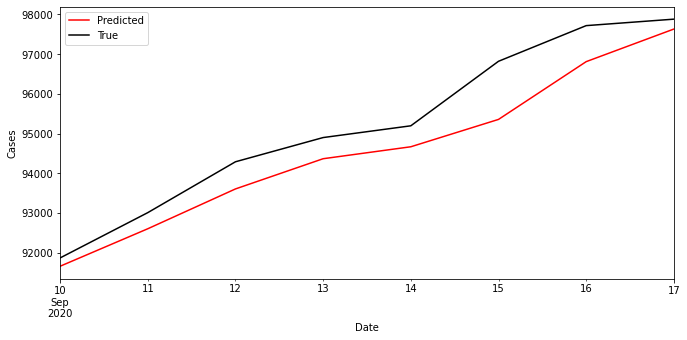

In [61]:
fig = plt.figure()
hac_2_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Belgium_hac", bbox_inches='tight')

SMAPE Hierarchical 2:

In [62]:
round(SMAPE(hac_2_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.6529

Saving result to parquet file:

In [63]:
#hac_2_CB_df.to_parquet('../results/forecasting_results/forecast_with_hac_beligum.parquet')

## K-means z trans, cluster 3

In [64]:
k_means_3_countries = pd.read_parquet('../results/clustering_results/df_kmeans_z_1.parquet')

In [65]:
k_means_3_countries_list = list(k_means_3_countries.columns)

List of countries in cluster:

In [66]:
k_means_3_countries_list

['Bahrain',
 'Bangladesh',
 'Belarus',
 'Chile',
 'Cuba',
 'Ghana',
 'Iran',
 'Kuwait',
 'Nigeria',
 'Oman',
 'Pakistan',
 'Peru',
 'Poland',
 'Qatar',
 'Russia',
 'Saudi Arabia',
 'Senegal',
 'Serbia',
 'Sri Lanka',
 'Sweden',
 'Togo',
 'United Arab Emirates',
 'United States',
 'Uruguay']

In [67]:
k_means_3_df = df[df['Country'].isin(k_means_3_countries_list)]

In [68]:
k_means_3_training_df = k_means_3_df[( k_means_3_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_3_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [69]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
k_means_3_CB_df = forecast(model=model, training_df=k_means_3_training_df.copy(), 
                                                             test_df=test_3_df.copy(),
                                                             feature_list=feature_list)



In [70]:
k_means_3_CB_df = accumulated_dataframe_column(Bangladesh_df,k_means_3_CB_df)

In [71]:
k_means_3_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1827.0,Bangladesh,331078.0,9,3,0.0,1892.0,2137.342307,331388
2020-09-11,1892.0,Bangladesh,332970.0,9,4,0.0,1827.0,1991.689993,333379
2020-09-12,1792.0,Bangladesh,334762.0,9,5,1.0,1892.0,2037.365591,335416
2020-09-13,1282.0,Bangladesh,336044.0,9,6,1.0,1792.0,1838.140314,337254
2020-09-14,1476.0,Bangladesh,337520.0,9,0,0.0,1282.0,1140.986351,338394
2020-09-15,1812.0,Bangladesh,339332.0,9,1,0.0,1476.0,1553.898320,339947
2020-09-16,1724.0,Bangladesh,341056.0,9,2,0.0,1812.0,1937.730272,341884
2020-09-17,1615.0,Bangladesh,342671.0,9,3,0.0,1724.0,1914.222642,343798


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

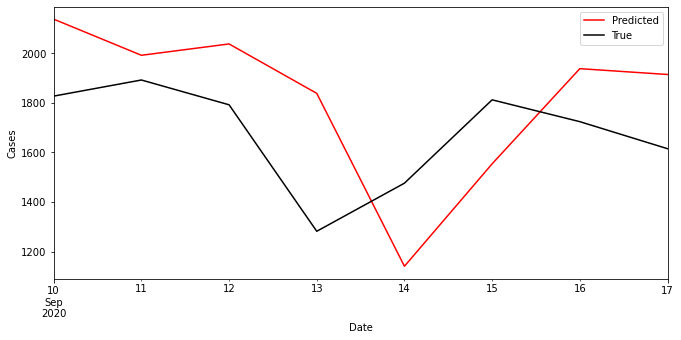

In [72]:
fig = plt.figure()
k_means_3_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

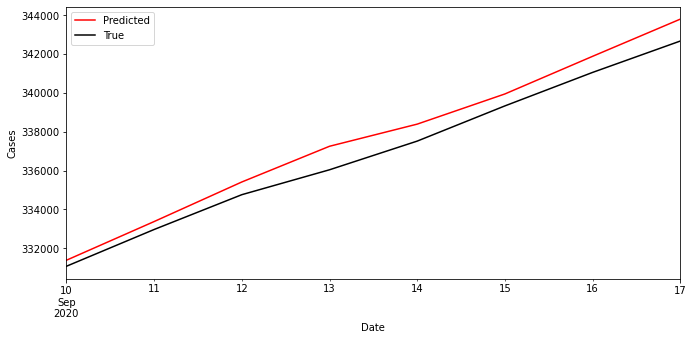

In [73]:
fig = plt.figure()
k_means_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Bangladesh_k_means", bbox_inches='tight')

SMAPE K-means 3:

In [74]:
round(SMAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2227

Saving result to parquet file:

In [75]:
#k_means_3_CB_df.to_parquet('../results/forecasting_results/forecast_with_k_means_bangladesh.parquet')

## Hierarchical z trans, cluster 3

In [76]:
hac_3_countries = pd.read_parquet('../results/clustering_results/df_hac_z_2.parquet')

In [77]:
hac_3_countries_list = list(hac_3_countries.columns)

List of countries in cluster:

In [78]:
hac_3_countries_list

['Bahrain',
 'Bangladesh',
 'Belarus',
 'Chile',
 'Ghana',
 'Iran',
 'Kuwait',
 'Nigeria',
 'Oman',
 'Pakistan',
 'Peru',
 'Poland',
 'Qatar',
 'Russia',
 'Saudi Arabia',
 'Senegal',
 'Serbia',
 'Sri Lanka',
 'Sweden',
 'Togo',
 'United Arab Emirates',
 'United States']

In [79]:
hac_3_df = df[df['Country'].isin(hac_3_countries_list)]

In [80]:
hac_3_training_df = hac_3_df[(hac_3_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (hac_3_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [81]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
hac_3_CB_df = forecast(model=model, training_df=hac_3_training_df.copy(), 
                                                             test_df=test_3_df.copy(),
                                                             feature_list=feature_list)

In [82]:
hac_3_CB_df = accumulated_dataframe_column(Bangladesh_df,hac_3_CB_df)

In [83]:
hac_3_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,1827.0,Bangladesh,331078.0,9,3,0.0,1892.0,2060.506894,331311
2020-09-11,1892.0,Bangladesh,332970.0,9,4,0.0,1827.0,1960.986204,333271
2020-09-12,1792.0,Bangladesh,334762.0,9,5,1.0,1892.0,1939.458104,335210
2020-09-13,1282.0,Bangladesh,336044.0,9,6,1.0,1792.0,1843.672406,337053
2020-09-14,1476.0,Bangladesh,337520.0,9,0,0.0,1282.0,1344.508525,338397
2020-09-15,1812.0,Bangladesh,339332.0,9,1,0.0,1476.0,1638.743577,340035
2020-09-16,1724.0,Bangladesh,341056.0,9,2,0.0,1812.0,1833.290365,341868
2020-09-17,1615.0,Bangladesh,342671.0,9,3,0.0,1724.0,1809.668263,343677


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

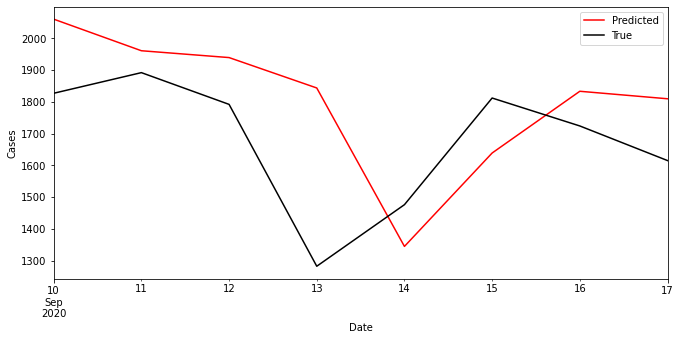

In [84]:
fig = plt.figure()
hac_3_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

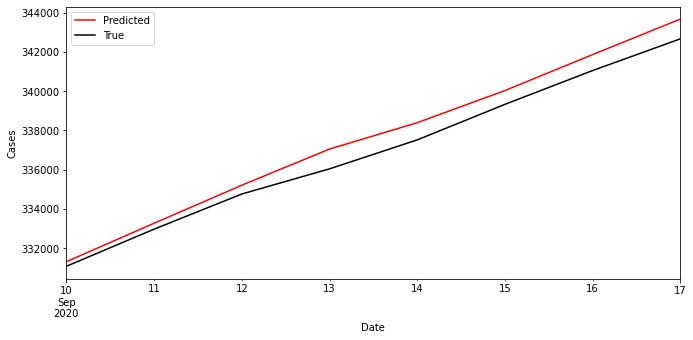

In [85]:
fig = plt.figure()
hac_3_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Bangladesh_hac", bbox_inches='tight')

SMAPE Hierarchical 3:

In [86]:
round(SMAPE(hac_3_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.199

Saving result to parquet file:

In [87]:
#hac_3_CB_df.to_parquet('../results/forecasting_results/forecast_with_hac_bangladesh.parquet')

## K-means z trans, cluster 4

In [88]:
k_means_4_countries = pd.read_parquet('../results/clustering_results/df_kmeans_z_0.parquet')

In [89]:
k_means_4_countries_list = list(k_means_4_countries.columns)

List of countries in cluster:

In [90]:
k_means_4_countries_list

['Croatia',
 'Czech Republic',
 'Greece',
 'Hungary',
 'Malta',
 'Morocco',
 'Myanmar',
 'Paraguay',
 'Slovakia',
 'Slovenia',
 'South Korea',
 'Tunisia']

In [91]:
k_means_4_df = df[df['Country'].isin(k_means_4_countries_list)]

In [92]:
k_means_4_training_df = k_means_4_df[(k_means_4_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (k_means_4_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [93]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
k_means_4_CB_df = forecast(model=model, training_df=k_means_4_training_df.copy(), 
                                                             test_df=test_4_df.copy(),
                                                             feature_list=feature_list)

In [94]:
k_means_4_CB_df = accumulated_dataframe_column(Croatia_df,k_means_4_CB_df)

In [95]:
k_means_4_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,341.0,Croatia,12626.0,9,3,0.0,204.0,279.258777,12564
2020-09-11,291.0,Croatia,12917.0,9,4,0.0,341.0,343.592684,12907
2020-09-12,190.0,Croatia,13107.0,9,5,1.0,291.0,281.550985,13188
2020-09-13,261.0,Croatia,13368.0,9,6,1.0,190.0,191.746712,13379
2020-09-14,165.0,Croatia,13533.0,9,0,0.0,261.0,154.657799,13533
2020-09-15,65.0,Croatia,13598.0,9,1,0.0,165.0,148.150691,13681
2020-09-16,151.0,Croatia,13749.0,9,2,0.0,65.0,103.883144,13784
2020-09-17,280.0,Croatia,14029.0,9,3,0.0,151.0,249.421476,14033


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

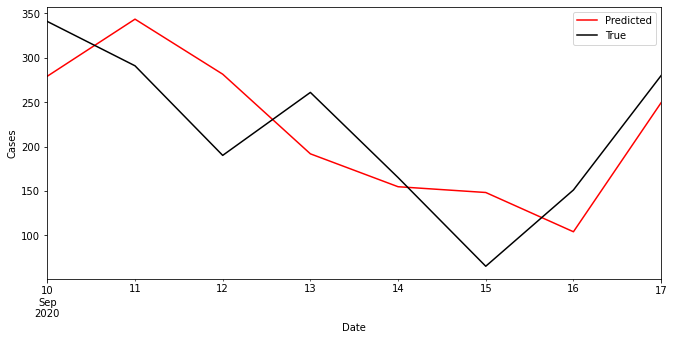

In [96]:
fig = plt.figure()
k_means_4_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

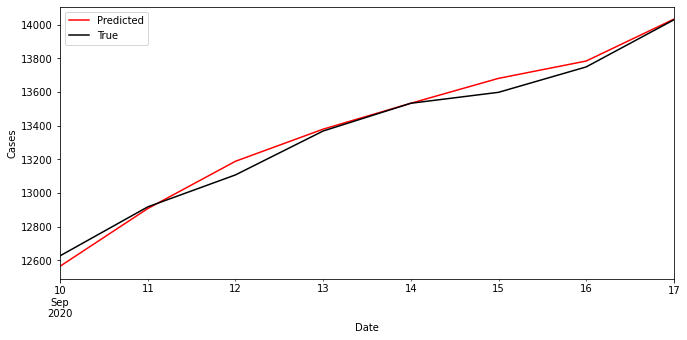

In [97]:
fig = plt.figure()
k_means_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Croatia_k_means", bbox_inches='tight')

SMAPE K-means 4:

In [98]:
round(SMAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.2699

Saving result to parquet file:

In [99]:
#k_means_4_CB_df.to_parquet('../results/forecasting_results/forecast_with_k_means_croatia.parquet')

## Hierarchical z trans, cluster 4

In [100]:
hac_4_countries = pd.read_parquet('../results/clustering_results/df_hac_z_0.parquet')

In [101]:
hac_4_countries_list = list(hac_4_countries.columns)

List of countries in cluster:

In [102]:
hac_4_countries_list

['Australia',
 'Austria',
 'Croatia',
 'Cuba',
 'Czech Republic',
 'Greece',
 'Hungary',
 'Japan',
 'Malta',
 'Myanmar',
 'Romania',
 'Slovakia',
 'Slovenia',
 'South Korea',
 'Tunisia',
 'Uruguay',
 'Vietnam']

In [103]:
hac_4_df = df[df['Country'].isin(hac_4_countries_list)]

In [104]:
hac_4_training_df = hac_4_df[(hac_4_df.index.date >= datetime.date(2020, 3, 1)) & 
                    (hac_4_df.index.date <= datetime.date(2020, 9, 9))].copy()

In [105]:
# Generate model
feature_list = ['Country','Month','Day','prev_case']
params= {'iterations': 5000, 'silent': True}
model = CatBoostRegressor(**params)
hac_4_CB_df = forecast(model=model, training_df=hac_4_training_df.copy(), 
                                                             test_df=test_4_df.copy(),
                                                             feature_list=feature_list)

In [106]:
hac_4_CB_df = accumulated_dataframe_column(Croatia_df,hac_4_CB_df)

In [107]:
hac_4_CB_df

,Cases,Country,cases_tot,Month,Day,Weekend,prev_case,Predicted,Accumulated_Prediction
Date,,,,,,,,,
2020-09-10,341.0,Croatia,12626.0,9,3,0.0,204.0,264.325808,12549
2020-09-11,291.0,Croatia,12917.0,9,4,0.0,341.0,340.561226,12889
2020-09-12,190.0,Croatia,13107.0,9,5,1.0,291.0,288.965297,13177
2020-09-13,261.0,Croatia,13368.0,9,6,1.0,190.0,201.830179,13378
2020-09-14,165.0,Croatia,13533.0,9,0,0.0,261.0,204.393279,13582
2020-09-15,65.0,Croatia,13598.0,9,1,0.0,165.0,216.023088,13798
2020-09-16,151.0,Croatia,13749.0,9,2,0.0,65.0,94.313709,13892
2020-09-17,280.0,Croatia,14029.0,9,3,0.0,151.0,225.420770,14117


Plot of true vs predicted when comparing cases per day and predicted cases per day:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

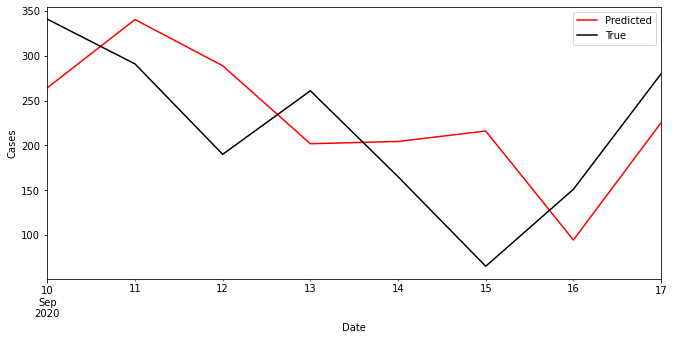

In [108]:
fig = plt.figure()
hac_4_CB_df.plot( y=['Predicted', 'Cases'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')

Plot of true vs. predicted when comparing total cases and accumulated prediction:

Text(0, 0.5, 'Cases')

<Figure size 432x288 with 0 Axes>

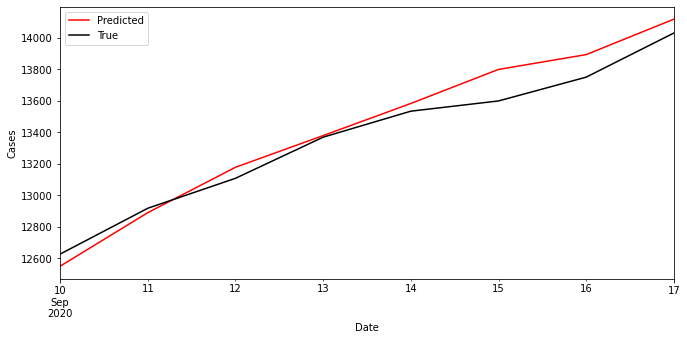

In [109]:
fig = plt.figure()
hac_4_CB_df.plot( y=['Accumulated_Prediction', 'cases_tot'], label=['Predicted','True'], color=['red','black'], figsize=(11,5))
plt.ylabel('Cases')
#plt.savefig("Croatia_hac", bbox_inches='tight')

SMAPE Hierarchical 4:

In [110]:
round(SMAPE(hac_4_CB_df,'cases_tot','Accumulated_Prediction'),4)

0.6147

Saving result to parquet file:

In [111]:
#hac_4_CB_df.to_parquet('../results/forecasting_results/forecast_with_hac_croatia.parquet')

## Summary:

In [112]:
table = [["Test Country:", "K_means SMAPE:", "HAC SMAPE:"],
        ["Algeria",round(SMAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction'),4),
        round(SMAPE(hac_1_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Belgium",round(SMAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction'),4),
        round(SMAPE(hac_2_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Bangladesh",round(SMAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction'),4),
        round(SMAPE(hac_3_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Croatia",round(SMAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4),
        round(SMAPE(hac_4_CB_df,'cases_tot','Accumulated_Prediction'),4)],
        ["Total SMAPE:",
         round(SMAPE(k_means_1_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(k_means_2_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(k_means_3_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(k_means_4_CB_df,'cases_tot','Accumulated_Prediction'),4),
         round(SMAPE(hac_1_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(hac_2_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(hac_3_CB_df,'cases_tot','Accumulated_Prediction')+
         SMAPE(hac_4_CB_df,'cases_tot','Accumulated_Prediction'),4)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Test Country:,K_means SMAPE:,HAC SMAPE:
Algeria,0.2163,0.323
Belgium,0.6949,0.6529
Bangladesh,0.2227,0.199
Croatia,0.2699,0.6147
Total SMAPE:,1.4037,1.7896
